## Candida albicans

This analysis solely focuses on the presence of Candida. It is based on the Aspergillus notebook.

## Import the libraries

In [1]:
import os
import sys
from socket import gethostname

hostname = gethostname()

import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
from matplotlib.colors import ListedColormap
import pandas as pd
import seaborn as sns
import json

from itertools import cycle

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import permutation_importance

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, roc_curve, auc

from scipy.stats import linregress


# there is a FutureWarning in sklearn StandardScalar which is really annoying. This ignores it.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

try:
  import google.colab
  IN_COLAB = True
  !pip install adjustText python-docx
  from google.colab import drive
  drive.mount('/content/drive')
  datadir = '/content/drive/MyDrive/Projects/CF/Adelaide/CF_Data_Analysis'
except ImportError:
  IN_COLAB = False
  datadir = '..'

from adjustText import adjust_text

if hostname.startswith('hpc-node'):
    IN_DEEPTHOUGHT = True
    sys.path.append('..')
else:
    IN_DEEPTHOUGHT = False
import cf_analysis_lib

In [2]:
sequence_type = "MGI"
sslevel = 'subsystems_norm_ss.tsv.gz'
taxa = "species"

df, metadata = cf_analysis_lib.read_the_data(sequence_type, datadir, sslevel=sslevel, taxa=taxa, all_taxa=True, verbose=True)

merged = df.join(metadata, how='inner')

print(f"The merged Data Frame has shape: {merged.shape}")

Read 127 samples and 769 subsystems
Read 127 samples and 31371 species
Read 127 samples and 166 metadata columns


The merged Data Frame has shape: (127, 32306)


# Who has Candida (should be about 40 samples)

In [4]:
for c in merged.columns:
    if 'candida' in c.lower() and 'candidate' not in c.lower():
        print(c)

Nonomuraea candida
Chryseobacterium candidae
Folsomia candida
uncultured Candida
Candida albicans
Candida blackwelliae
Candida bohioensis
Candida corydali
Candida dubliniensis
Candida gigantensis
Candida maltosa
Candida metapsilosis
Candida orthopsilosis
Candida oxycetoniae
Candida parapsilosis
Candida prachuapensis
Candida pseudojiufengensis
Candida tropicalis
Candida verbasci
Candida viswanathii
[Candida] oleophila
[Candida] railenensis
[Candida] subhashii
[Candida] auris
[Candida] duobushaemulonis
[Candida] haemuloni
[Candida] intermedia
[Candida] pseudohaemulonii
[Candida] norvegica
[Candida] arabinofermentans
[Candida] boidinii
[Candida] inconspicua
Albugo candida
CS_Candida albicans
N12M_Candida albicans


### A simple plot of _C. albicans_ vs. culturing

In [7]:
df['Candida albicans']

1068841_20180306_S      3.773297
1447437_20171212_S      0.635592
1128691_20171206_S      0.000000
1128691_20171218_S     33.855651
1128691_20180116_S     41.621144
                         ...    
895293_20180502_S       3.069456
896213_20180427_S     151.810540
913873_20180417_S       0.000000
980574_20180403_S       0.871822
983493_20180123_S       2.553535
Name: Candida albicans, Length: 127, dtype: float64

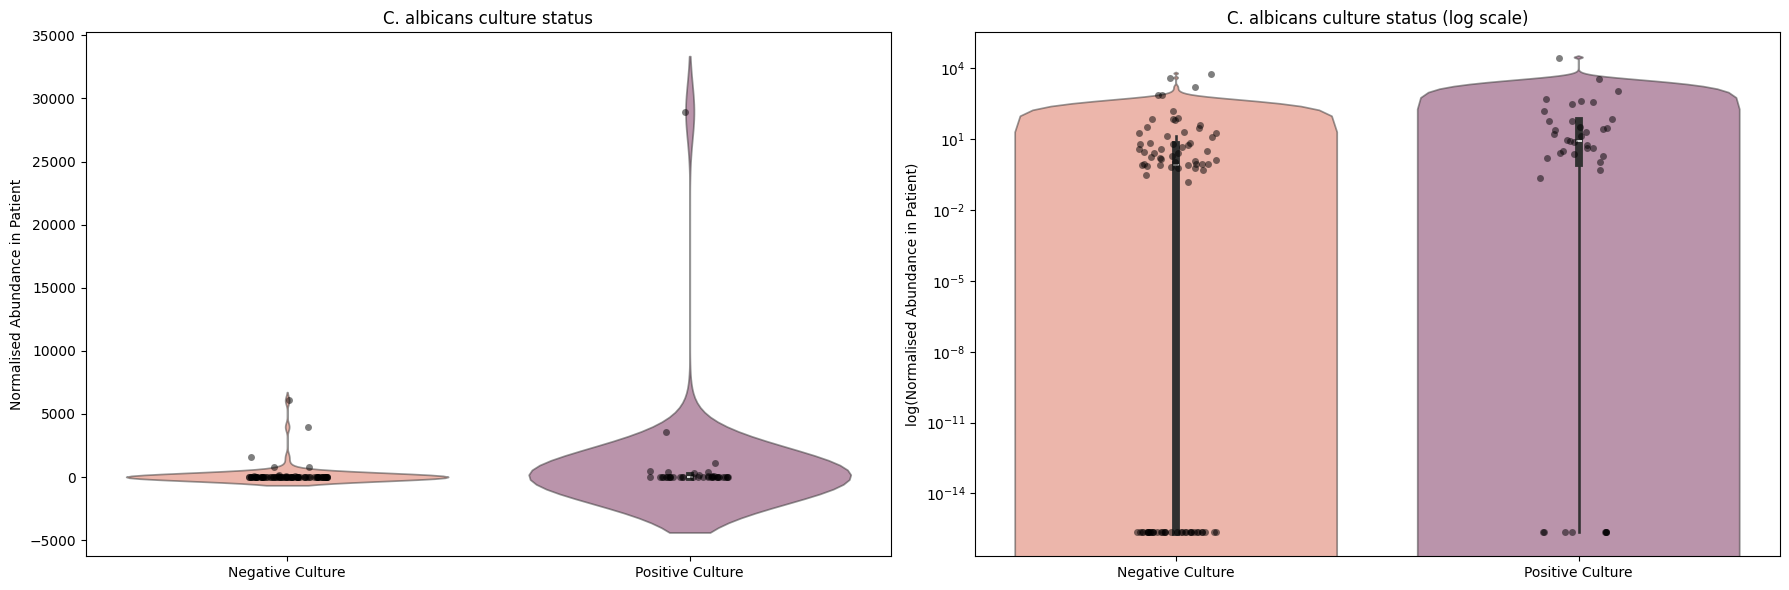

In [21]:
fig, ax = plt.subplots(figsize=(18, 6), nrows=1, ncols=2, sharex=False, sharey=False)

subset_data = merged[merged['CS_Candida albicans'].notna()]
subset_data['Candida albicans'] = subset_data['Candida albicans'] + sys.float_info.epsilon
f = sns.violinplot(x='CS_Candida albicans', y='Candida albicans', data=subset_data, hue='CS_Candida albicans', palette='rocket_r', ax=ax[0], alpha=0.5, legend=False)
f = sns.stripplot(x='CS_Candida albicans', y='Candida albicans', data=subset_data, color='black', jitter=True, alpha=0.5, ax=ax[0], legend=False)
f.set_xlabel("")
f.set_ylabel("Normalised Abundance in Patient")
f.set_xlim(-0.5, 1.5)
f.set_xticks(ticks=[0, 1], labels=["Negative Culture", "Positive Culture"])
f.set_title(f"C. albicans culture status")

g = sns.violinplot(x='CS_Candida albicans', y='Candida albicans', data=subset_data, hue='CS_Candida albicans', palette='rocket_r', ax=ax[1], alpha=0.5, legend=False)
g = sns.stripplot(x='CS_Candida albicans', y='Candida albicans', data=subset_data, color='black', jitter=True, alpha=0.5, ax=ax[1], legend=False)
g.set_xlabel("")
g.set_ylabel("log(Normalised Abundance in Patient)")
g.set_xlim(-0.5, 1.5)
g.set_xticks(ticks=[0, 1], labels=["Negative Culture", "Positive Culture"])
g.set_title(f"C. albicans culture status (log scale)")
g.set(yscale="log")

plt.tight_layout()
plt.show()

# ROC Curve

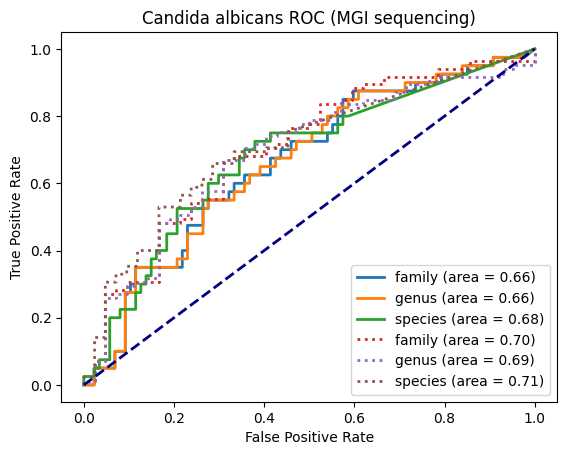

In [51]:
sequence_type = "MGI"
sslevel = 'subsystems_norm_ss.tsv.gz'
aspname = {'family': 'Debaryomycetaceae', 'genus': 'Candida', 'species': 'Candida albicans'}

plt.figure()

roc_data = pd.DataFrame()
for taxa in aspname:
    df, metadata = cf_analysis_lib.read_the_data(sequence_type, datadir, sslevel=sslevel, taxa=taxa, all_taxa=True, verbose=False)
    
    merged = df[[aspname[taxa]]].join(metadata[['pwCF_ID', 'Sample date', 'Sum of antifungals', 'CS_Candida albicans', 'N12M_Candida albicans']], how='inner')
    res = merged.sort_values(by=['pwCF_ID', 'Sample date'])
    
    y_true = res['CS_Candida albicans']
    y_scores = res[aspname[taxa]]

    roc_data[f'{taxa} true'] = y_true
    roc_data[f'{taxa} score'] = y_scores
    
    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{taxa} (area = {roc_auc:.2f})')

for taxa in aspname:
    df, metadata = cf_analysis_lib.read_the_data(sequence_type, datadir, sslevel=sslevel, taxa=taxa, all_taxa=True, verbose=False)
    
    merged = df[[aspname[taxa]]].join(metadata[['pwCF_ID', 'Sample date', 'Sum of antifungals', 'CS_Candida albicans', 'N12M_Candida albicans']], how='inner')
    res = merged.sort_values(by=['pwCF_ID', 'Sample date'])
    
    y_true = res[['CS_Candida albicans', 'N12M_Candida albicans']].astype(bool).any(axis=1)
    y_scores = res[aspname[taxa]]

    roc_data[f'{taxa} true'] = y_true
    roc_data[f'{taxa} score'] = y_scores
    
    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, linestyle=':', label=f'{taxa} (area = {roc_auc:.2f})')


    
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Candida albicans ROC ({sequence_type} sequencing)')
plt.legend(loc="lower right")
plt.show()